This code is of document scanner so we will analyze results using this method 

There are few steps in it 
1. Morphological operation 
2. GrabCut 
3. Edge detection 
4. Detecting corner points 
5. Transform to align the document 

# Importing libraries

In [ ]:
import cv2 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# Image reading and preprocessing

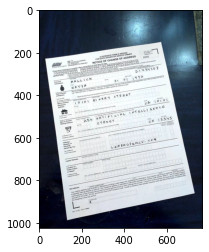

In [ ]:
img=cv2.imread('/content/receipt.jpg')
plt.imshow(img)

# Morphological operation

In morphological operation we make a blank space of our image so that content is not misleading in our edge detection

Morphlogy ex means erosion followed by dillution

In [ ]:
#defining a function for this puprose 
def morphology(img):
  kernel = np.ones((5,5),np.uint8)
  img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations= 4)
  return img

In [ ]:
morphed_img=morphology(img)

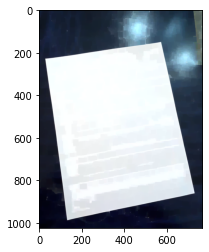

In [ ]:
plt.imshow(morphed_img)

# Grab Cut operations

Grabcut means iterative extraction of foreground in our image input 
1. it just requires a bounding box around the object that needs to be extracted 
2. If the bounding box contains both object and background then also it will remove the background from bounding box

It requires some parameters so we also need to define them 

In [ ]:
def grabcut(img):
  #first we need to create a mak image to load our results 
  mask = np.zeros(img.shape[:2],np.uint8) 
  # we need to define two models named foreground and background models 
  #as our image is of 64x64 so we define in dimensions of (1,65)
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)
  #now the main part comes we need to define the rectangle for our detection 
  rect = (20,20,img.shape[1]-20,img.shape[0]-20)
  #now we can implement the grabcut algorithm 
  cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
  #this is our new mask image with four flags where 0 and 2 pixels are backfround and 1,3 are foreground it will give our main mask result 
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  #returning the image
  img = img*mask2[:,:,np.newaxis]
  return img

In [ ]:
grabcut_img=grabcut(morphed_img)

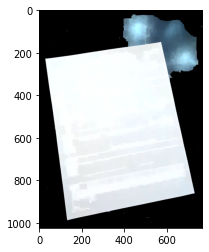

In [ ]:
plt.imshow(grabcut_img)

Till now the results are coming good as we can see that mainly the bill is detected and the backgrounds gets removed

# Edge detection

Till now we have a blank white page with  just black background so the edge detection will be more easily performed

Steps for this 
1. Gray image conversion 
2. Gaussian blurr for removing the noises from the image 
3. We can use the canny edge detector of opencv
4. dilate the image for thin outline as dilation adds pixels to boundary of image

After detection of edges we have to proceed with countours detection in tha image the steps for this are 
1. Firstly we have to detect the countours in edges and sort them 
2. keeping only the largest detected countour only 
3. Now drawing the countour on blank canvas


In [ ]:
def countours_detection(img):
  #conversion to gray 
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #applying gaussian blurr
  gray = cv2.GaussianBlur(gray, (11, 11), 0)
  # Edge Detection using canny edge detector
  canny = cv2.Canny(gray, 0, 200)
  #dilation of image
  canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
  #making a blank canvas for countours drwaing 
  con = np.zeros_like(img) 
  #finding countors using opencv 
  contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  #sorting the countours and keeping only the largest one 
  page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
  #now drawing the countours on blank canvas 
  con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
  return page,con

In [ ]:
page,countours=countours_detection(grabcut_img)

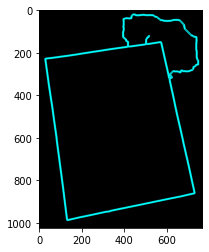

In [ ]:
plt.imshow(countours)

# Corner detection 

We need to detect corners in image for aligning the image correctly<br> 
for this purpose we will use cv2.approxPolyDP for approximating a polygon with lesser vertices<br> 
steps for following is 
1. Balnk canvas for drwaing vertices 
2. Looping through countours to getting the approximations 
3. Using approxPolyDP for corners detection 
4. If our approximated contour has four points then breaking the loop 
5. Drawing the countours 
6. Sorting the corners and then converting them to desired shape 
7. Now displaying the edges 

In [ ]:
def corner_detection(page, img):
  # Blank canvas.
  con = np.zeros_like(img)
  # Loop over the contours.
  for c in page:
    # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    # If our approximated contour has four points
    if len(corners) == 4:
        break
  cv2.drawContours(con, c, -1, (0, 255, 255), 3)
  cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
  # Sorting the corners and converting them to desired shape.
  corners = sorted(np.concatenate(corners).tolist())
  
  # Displaying the corners.
  for index, c in enumerate(corners):
    character = chr(65 + index)
    img=cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
  
  return corners,img

In [ ]:
corners,corner_img=corner_detection(page,grabcut_img)

In [ ]:
corners

[[32, 231], [134, 984], [568, 152], [726, 858]]

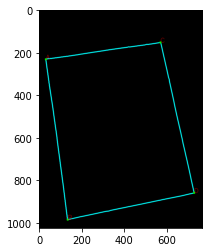

In [ ]:
plt.imshow(corner_img)

# Rearranging all these into order

In [ ]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

In [ ]:
pts=order_points(corners)

# FINDING the destination cordinates 

Now finding the destined cordinates 
1. first seperating the points 
2. finding the max width 
3. finding max height 
4. now we can have our final destination coordinates

In [ ]:
def dest_cordinates(pts):
  #sperating from points
  (tl, tr, br, bl) = pts
  # Finding the maximum width.
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))
  # Finding the maximum height.
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))
  # Final destination co-ordinates.
  destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
  return destination_corners

In [ ]:
dest_cors=dest_cordinates(pts)

# Shwowing the aligned image

1. getting perspective transform using open cv
2. Now getting the final image using warppersecptive

In [ ]:
def aligned_img(corners,dest_cors,img):
  # Getting the homography.
  M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(dest_cors))
  # Perspective transform using homography.
  final = cv2.warpPerspective(img, M, (dest_cors[2][0], dest_cors[2][1]), flags=cv2.INTER_LINEAR)
  return final

In [ ]:
final_img=aligned_img(pts,dest_cors,img)

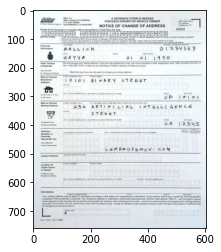

In [ ]:
plt.imshow(final_img)

We can see that our image is fully aligned now 

# Making a combined image

In [ ]:
def register_img(img):
  morphed_img=morphology(img)
  grabcut_img=grabcut(morphed_img)
  page,countours=countours_detection(grabcut_img)
  corners,corner_img=corner_detection(page,grabcut_img)
  pts=order_points(corners)
  dest_cors=dest_cordinates(pts)
  final_img=aligned_img(pts,dest_cors,img)
  return final_img

In [ ]:
final_img=register_img(img)

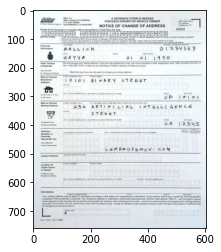

In [ ]:
plt.imshow(final_img)

Taking some examples from our original data

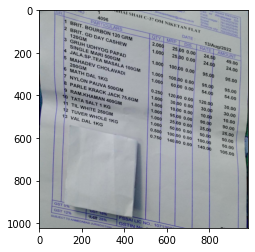

In [ ]:
img2=cv2.imread('/content/drive/MyDrive/bill/WhatsApp Image 2022-08-29 at 10.07.13 PM.jpeg')
final_img2=register_img(img2)
plt.imshow(final_img2)

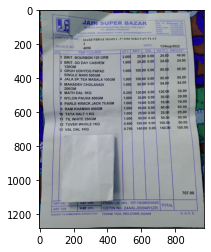

In [ ]:
plt.imshow(img2)

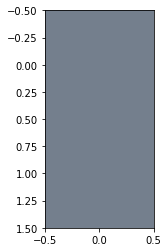

In [ ]:
img4=cv2.imread('/content/drive/MyDrive/bill/WhatsApp Image 2022-08-29 at 10.10.58 PM.jpeg')
final_img4=register_img(img4)
plt.imshow(final_img4)

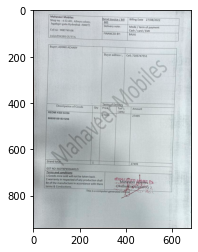

In [ ]:
img5=cv2.imread('/content/drive/MyDrive/bill/WhatsApp Image 2022-08-29 at 10.13.12 PM.jpeg')
final_img5=register_img(img5)
plt.imshow(final_img5)

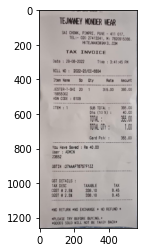

In [ ]:
img6=cv2.imread('/content/drive/MyDrive/bill/WhatsApp Image 2022-08-29 at 10.15.02 PM.jpeg')
final_img6=register_img(img6)
plt.imshow(final_img6)

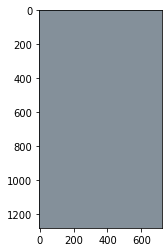

In [ ]:
img6=cv2.imread('/content/drive/MyDrive/bill/WhatsApp Image 2022-08-29 at 10.20.02 PM.jpeg')
final_img6=register_img(img6)
plt.imshow(final_img6)

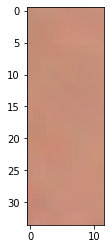

In [ ]:
img7=cv2.imread('/content/drive/MyDrive/bill/WhatsApp Image 2022-08-29 at 3.03.21 PM.jpeg')
final_img7=register_img(img7)
plt.imshow(final_img7)

In some cases it worked good but in some cases it didn't performed well so we need more optimized method